# **Install XGBoost**

In [1]:
!pip install xgboost

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "17"

* Load the new COVID cases from the *Our World in Data* dataset.

In [3]:
import pandas as pd

owid_covid = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")
owid_covid["date"] = pd.to_datetime(owid_covid["date"])
df = owid_covid[owid_covid.location == "France"].set_index("date", drop=True).resample('D').interpolate(method='linear').reset_index()

* A transformer is basically a class
with fit() and transform() methods that can make the transformer adapt to a
dataset and transform the data accordingly.
* The code for the DateFeatures
transformer annotates a dataset according to a date.
* This transformer is relatively simple in that it extracts a range of features for a date column such as hours, years, days, weekday, months, week of year, and quarter.
* These features can potentially be very powerful for describing or annotating the time-series data in a machine learning context.

In [4]:
from sklearn.base import TransformerMixin, BaseEstimator
from typing import List

class DateFeatures(TransformerMixin, BaseEstimator):
    """DateFeatures transformer."""
    features = [
        "hour",
        "year",
        "day",
        "weekday",
        "month",
        "quarter",
    ]
    
    def __init__(self):
        """Nothing much to do."""
        super().__init__()
        self.feature_names: List[str] = []

    def get_feature_names(self):
        """Feature names."""
        return self.feature_names
        
    def transform(self, df: pd.DataFrame):
        """Annotate date features."""
        Xt = []
        for col in df.columns:
            for feature in self.features:
                date_feature = getattr(
                    getattr(
                        df[col], "dt"
                    ), feature
                )
                date_feature.name = f"{col}_{feature}"
                Xt.append(date_feature)
        
        df2 = pd.concat(Xt, axis=1)
        self.feature_names = list(df2.columns)
        return df2

    def fit(self, df: pd.DataFrame, y=None, **fit_params):
        """No fitting needed."""
        return self

In [5]:
import numpy as np
from sklearn.base import TransformerMixin, BaseEstimator
from typing import Dict

class CyclicalFeatures(TransformerMixin, BaseEstimator):
    """CyclicalFeatures transformer."""
    
    def __init__(self, max_vals: Dict[str, float] = {}):
        """Nothing much to do."""
        super().__init__()
        self.feature_names: List[str] = []
        self.max_vals = max_vals

    def get_feature_names(self):
        """Feature names."""
        return self.feature_names
        
    def transform(self, df: pd.DataFrame):
        """Annotate date features."""
        Xt = []
        for col in df.columns:
            if col in self.max_vals:
                max_val = self.max_vals[col]
            else:
                max_val = df[col].max()
            for fun_name, fun in [("cos", np.cos), ("sin", np.sin)]:
                date_feature = fun(2 * np.pi * df[col] / max_val)
                date_feature.name = f"{col}_{fun_name}"
                Xt.append(date_feature)
        
        df2 = pd.concat(Xt, axis=1)
        self.feature_names = list(df2.columns)
        return df2

    def fit(self, df: pd.DataFrame, y=None, **fit_params):
        """No fitting needed."""
        return self

* Apply the transformers as follows to the date column of the DataFrame.
* The remainder="passthrough" argument is set in case that want to provide additional exogenous features for prediction.

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
#from sklearn import linear_model


preprocessor = ColumnTransformer(
    transformers=[(
        "date",
        make_pipeline(
            DateFeatures(),
            ColumnTransformer(transformers=[
                ("cyclical", CyclicalFeatures(),
                  ["date_day", "date_weekday", "date_month"]
                )
            ], remainder="passthrough")
        ), ["date"],
  ),], remainder="passthrough"
)

pipeline = Pipeline(
    [
        ("preprocessing", preprocessor),
        #("clf", linear_model.LinearRegression(),),
    ]
)

* Fit pipeline as follows.

In [7]:
FEATURE_COLS = ["date"]
date_features = pipeline.fit_transform(df[FEATURE_COLS])
date_features

array([[ 1.51427778e-01, -9.88468324e-01, -5.00000000e-01, ...,
         0.00000000e+00,  2.02000000e+03,  1.00000000e+00],
       [ 3.47305253e-01, -9.37752132e-01,  5.00000000e-01, ...,
         0.00000000e+00,  2.02000000e+03,  1.00000000e+00],
       [ 5.28964010e-01, -8.48644257e-01,  1.00000000e+00, ...,
         0.00000000e+00,  2.02000000e+03,  1.00000000e+00],
       ...,
       [-5.06491688e-02, -9.98716507e-01,  5.00000000e-01, ...,
         0.00000000e+00,  2.02100000e+03,  4.00000000e+00],
       [ 1.51427778e-01, -9.88468324e-01, -5.00000000e-01, ...,
         0.00000000e+00,  2.02100000e+03,  4.00000000e+00],
       [ 3.47305253e-01, -9.37752132e-01, -1.00000000e+00, ...,
         0.00000000e+00,  2.02100000e+03,  4.00000000e+00]])

* Align the features with values ahead of time.
* Split the dataset into two by a cutoff time.
* Take 90% of points for training, and predict 90 days into the future.

In [8]:
TRAIN_SIZE = int(len(df) * 0.9)
HORIZON = 1
TARGET_COL = "new_cases"

X_train, X_test = df.iloc[HORIZON:TRAIN_SIZE], df.iloc[TRAIN_SIZE+HORIZON:]
y_train = df.shift(periods=HORIZON).iloc[HORIZON:TRAIN_SIZE][TARGET_COL]
y_test = df.shift(periods=HORIZON).iloc[TRAIN_SIZE+HORIZON:][TARGET_COL]

* Define a pipeline of these preprocessing steps together with a model so that it can be fitted and applied to prediction.

In [9]:
from xgboost import XGBRegressor

pipeline = Pipeline(
    [
        ("preprocessing", preprocessor),
        ("xgb", XGBRegressor(objective="reg:squarederror", n_estimators=1000))
    ]
)
pipeline.fit(X_train[FEATURE_COLS], y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date',
                                                  Pipeline(steps=[('datefeatures',
                                                                   DateFeatures()),
                                                                  ('columntransformer',
                                                                   ColumnTransformer(remainder='passthrough',
                                                                                     transformers=[('cyclical',
                                                                                                    CyclicalFeatures(),
                                                                                                    ['date_day',
                                                                                                     'date_weekday',
                     

* Create a series of the dates from beginning to end, then can get the predictions of the model for the whole time period.

In [10]:
MAX_HORIZON = 90
X_test_horizon = pd.Series(pd.date_range(
    start=df.date.min(), 
    periods=len(df) + MAX_HORIZON,
    name="date"
)).reset_index()

* The predict() method of the pipeline applied to X_test.

In [11]:
forecasted = pd.concat(
    [pd.Series(pipeline.predict(X_test_horizon[FEATURE_COLS])), pd.Series(X_test_horizon.date)],
    axis=1
)
forecasted.columns = [TARGET_COL, "date"]

* Do the same for the actual cases.

In [12]:
actual = pd.concat(
    [pd.Series(df[TARGET_COL]), pd.Series(df.date)],
    axis=1
)
actual.columns = [TARGET_COL, "date"]

* Contrast the forecast with the actual values, y_test, in a plot.

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


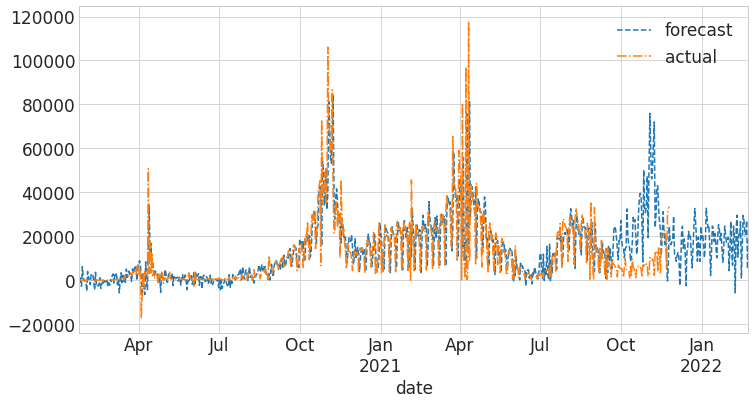

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
forecasted.set_index("date").plot(linestyle='--', ax=ax)
actual.set_index("date").plot(linestyle='-.', ax=ax)
plt.legend(["forecast", "actual"])

* Extract performance metrics over the test period.

In [14]:
from sklearn.metrics import mean_squared_error

test_data = actual.merge(forecasted, on="date", suffixes=("_actual", "_predicted"))

mse = mean_squared_error(test_data.new_cases_actual, test_data.new_cases_predicted, squared=False)  # RMSE
print("The root mean squared error (RMSE) on test set: {:.2f}".format(mse))

The root mean squared error (RMSE) on test set: 13867.15
